# Lecture 22 - Diffusion Models for Text-to-Image Generation

[![View notebook on Github](https://img.shields.io/static/v1.svg?logo=github&label=Repo&message=View%20On%20Github&color=lightgrey)](https://github.com/avakanski/Fall-2023-Python-Programming-for-Data-Science/blob/main/docs/Lectures/Theme_3-Model_Engineering/Lecture_19-Natural_Language_Processing/Lecture_19-NLP.ipynb)
[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/avakanski/Fall-2023-Python-Programming-for-Data-Science/blob/main/docs/Lectures/Theme_3-Model_Engineering/Lecture_19-Natural_Language_Processing/Lecture_19-NLP.ipynb)

<a id='top'></a>

- [22.1 Generative Text-to-Image Models](#22.1-generative-text-to-image-models)
- [22.2 High-Level API for Stable Diffusion with Keras](#22.2-high-level-api-for-stable-diffusion-with-keras)
- [22.3 Denoising Diffusion Probabilistic Models](#22.3-denoising-diffusion-probabilistic-models)
    - [22.3.1 Forward Diffusion Process](#22.3.1-forward-diffusion-process)
    - [22.3.2 Reverse Diffusion Process](#22.3.2-reverse-diffusion-process)
- [22.4 Text Encoder](#22.4-text-encoder)    
- [22.5 Latent Diffusion Models](#22.5-latent-diffusion-models)  
- [22.6 Generating Images with Stable Diffusion](#22.6-generating-images-with-stable-diffusion)  
- [Appendix](#appendix)  
- [References](#references)

## 22.1 Generative Text-to-Image Models <a name='22.1-generative-text-to-image-models'></a>

*Generative models* are a category of machine learning models that generate new data instances, typically by learning the data distribution of training instances. This is different from most models that we studied so far, such as *discriminative models* that can be used to classify the training instance into several classes, for example.

The family of GAN models (StyleGAN, CycleGAN, BigGAN) have been the most important category of generative models since the original GAN paper was published in 2014. Despite the remarkable progress in image synthesis achieved by the family of GAN models, these models are generally difficult to train due to their adversarial nature, as well as there is a lack of diversity in generated images.

Another group of generative models have recently had a great impact on image generation, referred to as **Denoising Diffusion Probabilistic Models** (DDPMs), or they are also simply called Diffusion Models. Diffusion Models convert Gaussian random noise into images from a learned data distribution in an iterative denoising process. This approach is inspired by the physical process of gas diffusion, and has also applications in other scientific fields. Diffusion Models have demonstrated an ability to generate images with increased quality and diversity in comparison to GANs, and they don't suffer from mode collapse and other training instabilities that are characteristical for GANs.

Examples of recent text-to-image generative methods that are based on Diffifusion Models include [DALL-E 2](https://openai.com/dall-e-2/) by OpenAI, [Stable Diffusion](https://github.com/CompVis/latent-diffusion) by Stability.AI, and [ImageGen](https://imagen.research.google/) by Google Brain.

Text-to-image generative models rely on learned representations by large language models that are trained on pairs of images and image captions. These representations  are afterward used to guide a Diffusion Model in generating new images given a text prompt.

This group of models can also take an input image as a prompt, and generate an image similar to the input image. For instance, we can quickly draw a simple drawing manually, and use it to create a photorealistic image.

Stable Diffusion was the first text-to-image model that was open-sourced this year, and this motivated a large number of recent applications.



## 22.2 High-Level API for Stable Diffusion with Keras <a name='22.2-high-level-api-for-stable-diffusion-with-keras'></a>

Let's first show an example of a high-level API for generating images from text prompts, and afterward we will explain the components in text-to-image models.

The code in the next cells employs a Keras library called `keras_cv` that implements the Stable Diffusion model. To run the model we need to first install `keras_cv` package. Afterward, we can just load a Stable Diffusion model and give a prompt to generate images.

In [1]:
!pip install keras_cv --upgrade --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 803.1/803.1 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 18.7 MB/s eta 0:00:00


In [2]:
import keras_cv
from tensorflow import keras
import matplotlib.pyplot as plt

Using TensorFlow backend


In [3]:
# Instantiate a Stable Diffusion model
model = keras_cv.models.StableDiffusion(img_width=512, img_height=512)

By using this model checkpoint, you acknowledge that its usage is subject to the terms of the CreativeML Open RAIL-M license at https://raw.githubusercontent.com/CompVis/stable-diffusion/main/LICENSE


In [ ]:
# generate images (it takes less than 1 minute with Google Colab Pro)
images = model.text_to_image("photograph of an astronaut riding a horse", batch_size=3)

# plot the images
plt.figure(figsize=(30, 10))
for i in range(len(images)):
    ax = plt.subplot(1, len(images), i + 1)
    plt.imshow(images[i])
    plt.axis("off")

20/50 [===========>..................] - ETA: 15s

In [ ]:
# generate images (it takes abut 1 minute per image with Google Colab Pro)
images = model.text_to_image("ruins of an ancient castle in a desert, concept art", batch_size=3)

# plot the images
plt.figure(figsize=(30, 10))
for i in range(len(images)):
    ax = plt.subplot(1, len(images), i + 1)
    plt.imshow(images[i])
    plt.axis("off")

In [ ]:
# generate images
images = model.text_to_image("a cute magical flying dog, fantasy art, golden color, high quality, highly detailed, elegant, sharp focus,"
    "concept art, character concepts, digital painting, mystery, adventure",  batch_size=3)

# plot the images
plt.figure(figsize=(30, 10))
for i in range(len(images)):
    ax = plt.subplot(1, len(images), i + 1)
    plt.imshow(images[i])
    plt.axis("off")

## 22.3 Denoising Diffusion Probabilistic Models <a name='22.3-denoising-diffusion-probabilistic-models'></a>

Denoising diffusion probabilistic process consists of two phases:

1. *Forward diffusion process*, in which Gaussian noise is gradually added to an image, until the image becomes complete random noise.
2. *Reverse diffusion process*, in which the image with Gaussian noise is gradually denoised, until all noise is removed and the original image is recovered.

### 22.3.1 Forward Diffusion Process <a name='22.3.1-forward-diffusion-process'></a>

For an initial image denoted ${x}_0$ that is sampled from the data distribution $q(x)$, the forward diffusion process adds noise over $T$ consecutive steps. At each step, the added Gaussian noise has variance $\beta_{t}$. I.e., the sample ${x}_{t}$ that corresponds to the step $t$ of the forward process, is obtained by adding Gaussian noise to the sample ${x}_{t-1}$ from step $t−1$. Therefore the conditional probability density of the forward diffusion process $q({x}_t |{x}_{t-1})$ can be written as:

$$
q({x}_{t}\mid{x}_{t-1}) = \mathcal{N}({x}_{t} ; \sqrt{1-\beta_{t}}{x}_{t-1},\beta_{t}\mathbf{I})
$$

The above notation means that ${x}_t$ has Gaussian distribution, with a mean $\sqrt{1-\beta_{t}}{x}_{t-1}$ and variance $\beta_{t}\mathbf{I}$.

This process is depicted in the next figure.

<img src="images/forward-diffusion.png" width="700">

*Figure: Forward diffusion process.*

Such process where the probability of an event at any given state is dependent only on the immediately preceding state is called *Markov Chain* or *Markov Process*.

The mean and variance of the samples depend on a parameter $\beta_{t}$, which defines the level of added Gaussian noise. The value of $\beta_{t}$ can either be constant for all steps, or it can be gradually changed (e.g., by using a sigmoid, cosine, tanh, linear function, etc).

Substituting $\alpha_{t}=1-\beta_{t}$, and $\bar{\alpha}_{t} = \prod_{s=1}^{t} \alpha_{s}$, the distribution can also be rewritten as:

$$
q({x}_{t}\mid{x}_{0}) = \mathcal{N}({x}_{t} ; \sqrt{\bar{\alpha}_{t}}{x}_{t-1},(1-\bar{\alpha}_{t})\mathbf{I})
$$

This substitution allows to draw samples at any timestep by using only the initial image $x_0$, without going through the intermediate steps. Hence, the variable ${x}_{t}$ of the forward diffusion can be written in terms of the initial image $x_0$ and the random Gaussian noise $\epsilon \sim \mathcal{N}(0,1)$ as:

$$
x_t(x_0,\epsilon) = \sqrt{\bar{\alpha}_{t}}{x}_{0} + \sqrt{1-\bar{\alpha_{t}}}\epsilon          
$$

Note that the forward diffusion process does not involve learning. It is a simple process that just applies noise to an image.

#### Example of Forward Diffusion

An example of performing forward diffusion is shown below, based on the code repository at [https://github.com/azad-academy/denoising-diffusion-model](https://github.com/azad-academy/denoising-diffusion-model).

The codes in the next cells apply Gaussian noise to an image of the letter S over 100 steps. In the figure below, the images for every 10th step of the noise-adding process are shown.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd 'drive/MyDrive/Data_Science_Course/Lecture_22-Diffusion_Models/helper_functions/'

/content/drive/MyDrive/Data_Science_Course/Fall_2023/Lecture_22-Diffusion_Models/helper_functions


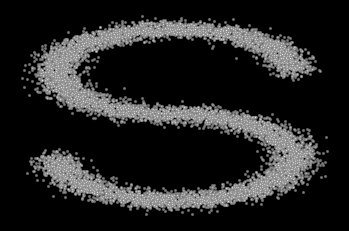

In [ ]:
# code from: https://github.com/azad-academy/denoising-diffusion-model

import numpy as np
from sklearn.datasets import make_s_curve
import matplotlib.pyplot as plt
from helper_plot import hdr_plot_style
import torch
from utils import *

# create S curve
s_curve, _= make_s_curve(10**4, noise=0.1)
s_curve = s_curve[:, [0, 2]]/10.0

data = s_curve.T

# plot the S curve
hdr_plot_style()
plt.scatter(*data, alpha=0.5, color='white', edgecolor='gray', s=5)
plt.axis('off')

dataset = torch.Tensor(data.T).float()

In [ ]:
num_steps = 100

# apply a sigmoid schedule for the beta parameter
betas = make_beta_schedule(schedule='sigmoid', n_timesteps=num_steps, start=1e-5, end=0.5e-2)

# substitute alphas
alphas = 1 - betas
alphas_prod = torch.cumprod(alphas, 0)
alphas_prod_p = torch.cat([torch.tensor([1]).float(), alphas_prod[:-1]], 0)
alphas_bar_sqrt = torch.sqrt(alphas_prod)
one_minus_alphas_bar_log = torch.log(1 - alphas_prod)
one_minus_alphas_bar_sqrt = torch.sqrt(1 - alphas_prod)

In [ ]:
# draw a sample at step t, given an initial image x_0
def q_x(x_0, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x_0)
    alphas_t = extract(alphas_bar_sqrt, t, x_0)
    alphas_1_m_t = extract(one_minus_alphas_bar_sqrt, t, x_0)
    return (alphas_t * x_0 + alphas_1_m_t * noise)

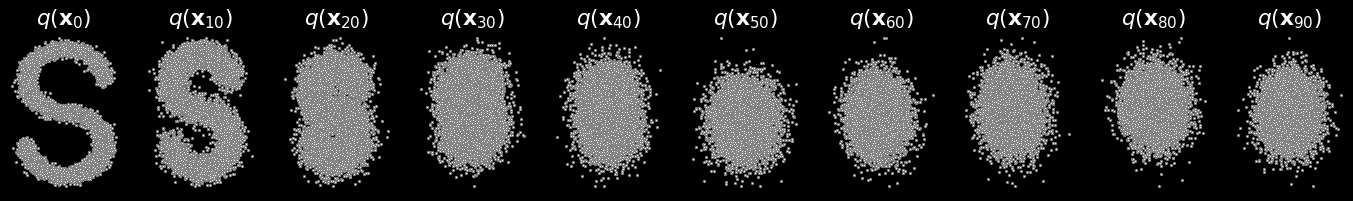

In [ ]:
# plot the samples for steps 0, 10, 20, ..., 90
fig, axs = plt.subplots(1, 10, figsize=(24, 3))
for i in range(10):
    q_i = q_x(dataset, torch.tensor([i * 10]))
    axs[i].scatter(q_i[:, 0], q_i[:, 1], color='white', edgecolor='gray', s=5)
    axs[i].set_axis_off(); axs[i].set_title('$q(\mathbf{x}_{'+str(i*10)+'})$')

As mentioned above, we can obtain a sample at any desired step in the forward diffusion process, by applying the level of Gaussian noise directly to the initial image. The cell below shows the image at step 15.

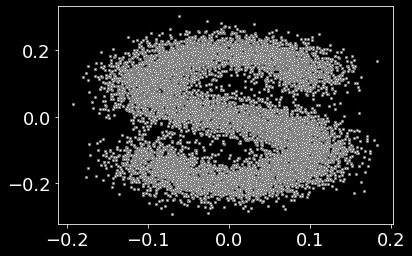

In [ ]:
# image in the 15th step
q_15 = q_x(dataset, torch.tensor([15]))
plt.scatter(q_15[:, 0], q_15[:, 1], color='white', edgecolor='gray', s=5);

### 22.3.2 Reverse Diffusion Process <a name='22.3.2-reverse-diffusion-process'></a>

The goal of the reverse diffusion process is to denoise the images from the forward diffusion process, i.e., start with a noisy image and obtain a clean image. Accurately calculating the reverse process $q({x}_{t-1}|{x}_{t})$ is intractable, and therefore, text-to-image models apply deep neural networks to approximate the probability density function $q({x}_{t-1}|{x}_{t})$ with a parameterized model $p_{\theta}({x}_{t-1}|{x}_{t})$, where $\theta$ denotes the parameters of the deep neural network model that are learned. The model takes as input a noisy image at step ${x}_{t}$ and predicts the mean $\mu_\theta({x}_{t},t)$ and the variance $\Sigma_\theta ({x}_{t},t)$ of a denoised image ${x}_{t-1}$.

$$ p_\theta ({x}_{t-1} | {x}_t) = \mathcal{N}({x}_{t-1}; \mu_\theta({x}_{t},t), \Sigma_\theta ({x}_{t},t))$$

<img src="images/reverse-diffusion-diffusion.png" width="700">

*Figure: Reverse diffusion process.*

#### Example of Reverse Diffusion

The reverse diffusion process for the image S from the above example is presented below. The mathematical expressions for calculating the posteriors are omitted here, and can be found in reference [3]. The model is trained for 1,000 iterations, and the denoising images at steps 0, 250, 500, 750, and 1,000 are shown in the figure below. In the last row of images, we can see that the model begins with a noisy image on the left and it ends with a denoised image on the right.

In [ ]:
posterior_mean_coef_1 = (betas * torch.sqrt(alphas_prod_p) / (1 - alphas_prod))
posterior_mean_coef_2 = ((1 - alphas_prod_p) * torch.sqrt(alphas) / (1 - alphas_prod))
posterior_variance = betas * (1 - alphas_prod_p) / (1 - alphas_prod)
posterior_log_variance_clipped = torch.log(torch.cat((posterior_variance[1].view(1, 1), posterior_variance[1:].view(-1, 1)), 0)).view(-1)

def q_posterior_mean_variance(x_0, x_t, t):
    coef_1 = extract(posterior_mean_coef_1, t, x_0)
    coef_2 = extract(posterior_mean_coef_2, t, x_0)
    mean = coef_1 * x_0 + coef_2 * x_t
    var = extract(posterior_log_variance_clipped, t, x_0)
    return mean, var

The U-Net model is imported in the next cell, and the model is trained for 1,000 iterations.

Iteration: 0
Iteration: 250
Iteration: 500
Iteration: 750
Iteration: 999


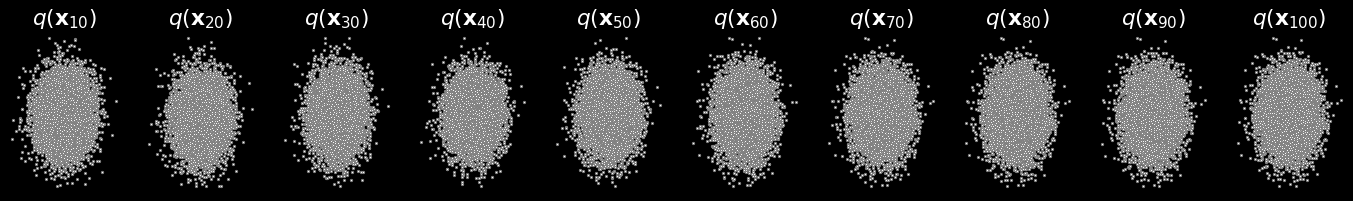

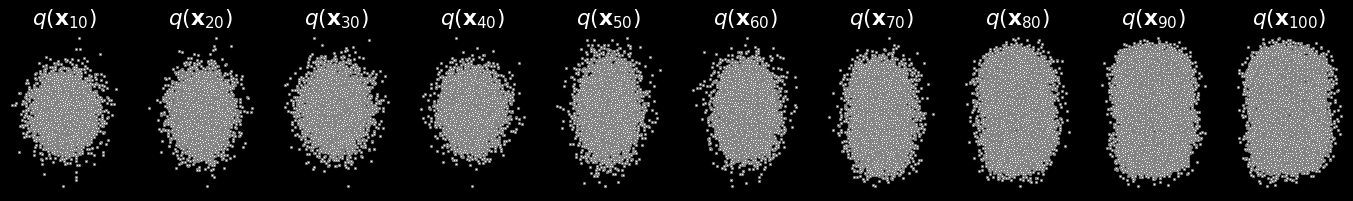

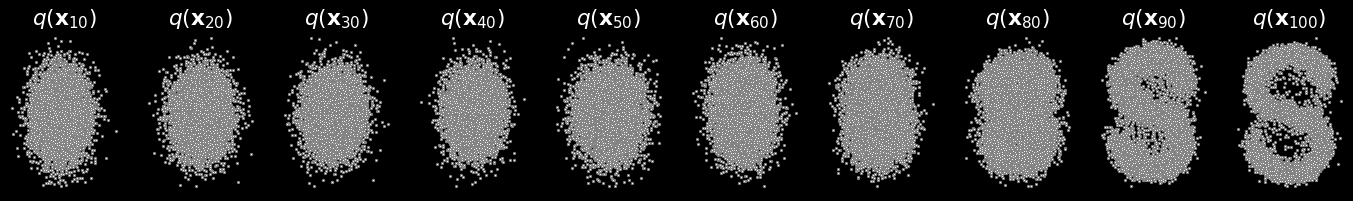

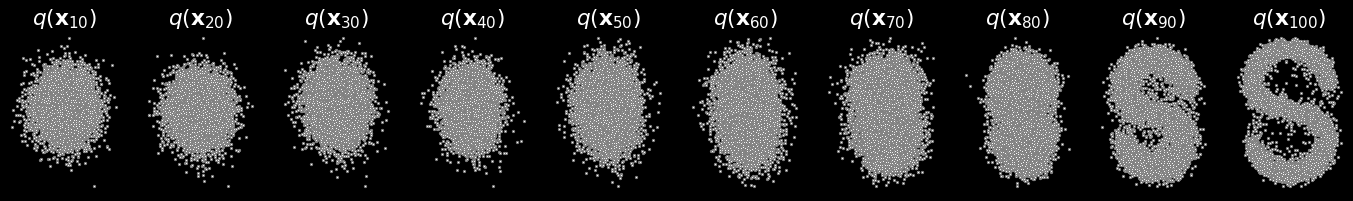

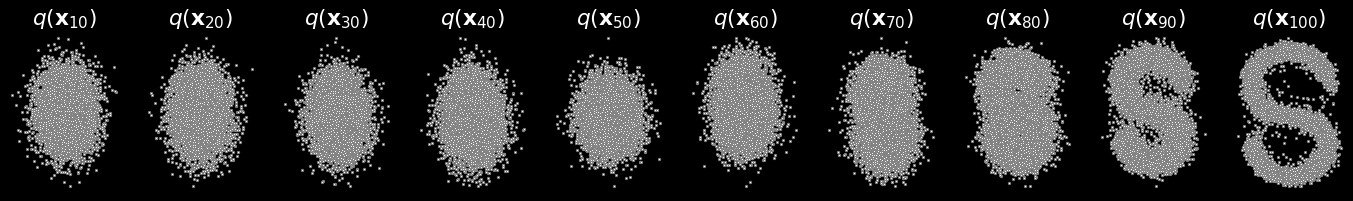

In [ ]:
from model import ConditionalModel
from ema import EMA
import torch.optim as optim

model = ConditionalModel(num_steps)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
# Create EMA model
ema = EMA(0.9)
ema.register(model)
# Batch size
batch_size = 128

# training
for t in range(1000):
    # X is a torch Variable
    permutation = torch.randperm(dataset.size()[0])
    for i in range(0, dataset.size()[0], batch_size):
        # Retrieve current batch
        indices = permutation[i:i+batch_size]
        batch_x = dataset[indices]
        # Compute the loss
        loss = noise_estimation_loss(model, batch_x,alphas_bar_sqrt,one_minus_alphas_bar_sqrt,num_steps)
        # Before the backward pass, zero all of the network gradients
        optimizer.zero_grad()
        # Backward pass: compute gradient of the loss with respect to parameters
        loss.backward()
        # Perform gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.)
        # Calling the step function to update the parameters
        optimizer.step()
        # Update the exponential moving average
        ema.update(model)
    # Print loss
    if (t % 250==0) or (t==999):
        print('Iteration:', t)
        x_seq = p_sample_loop(model, dataset.shape,num_steps,alphas,betas,one_minus_alphas_bar_sqrt)
        fig, axs = plt.subplots(1, 10, figsize=(24, 3))
        for i in range(1, 11):
            cur_x = x_seq[i * 10].detach()
            axs[i-1].scatter(cur_x[:, 0], cur_x[:, 1],color='white',edgecolor='gray', s=5);
            axs[i-1].set_axis_off();
            axs[i-1].set_title('$q(\mathbf{x}_{'+str(i*10)+'})$')

The gif image of the reverse diffusion process is shown below.

<img src='https://raw.githubusercontent.com/avakanski/Fall-2022-Python-Programming-for-Data-Science/main/Lectures/Theme%203%20-%20Model%20Engineering%20Pipelines/Lecture%2022%20-%20Diffusion%20Models/images/diffusion_S.gif' width=500px/>

#### U-Net Model for Reverse Diffusion

A U-Net model is used for the reverse diffusion phase. **U-Net** is a popular deep learning network for image segmentation. The name is due to the architecture that looks like the letter U. It includes an encoder sub-network that extracts lower-dimensional representations, and a decoder sub-network that reconstructs the representations to full size images. I.e., the encoder first downsamples the input image (reducing its size), and afterward the decoder upsamples the representations to the size of the original image. Another important part of U-Net  the *skip connections* which connect the feature maps from the encoder to the decoder, and help with the gradient flow. When U-Net is used for image segmentation, the inputs are images, and the outputs are segmentation masks that segment the objects in the input images.

<img src="images/unet.png" width="600">

*Figure: U-Net network.*

In diffusion models, inputs to U-Net are noisy images at a particular time step for the forward diffusion process, and outputs are the denoised images from the previous step. The model starts from step $T$, and at each step it creates a slighly less denoised image ${x}_{t-1 }$, until step $0$.

## 22.4 Text Encoder <a name='22.4-text-encoder'></a>

To generate images based on a text prompt, text-to-image models employ text embeddings from a Language Model. In particular, the model CLIP (Contrastive Language Image Pretraining) has been used by several of these models.

CLIP employs a Transformer Network architecture, and it was trained on a dataset of images and image captions.

<img src="images/images-and-captions-dataset.png" width="800">

*Figure: Images and captions dataset.*

CLIP has a text encoder and image encoder sub-networks, and the model is designed to match text in image captions to images. During training, the model creates text and image embeddings, and learns to group together text and image embeddings that correspond to the same object. By repeating the training over a large dataset of images and image captions, the model produces an embeddings space of matched text and images for a large number of objects.

<img src="images/clip-training.png" width="800">

*Figure: CLIP model.*

## 22.5 Latent Diffusion Models <a name='22.5-latent-diffusion-models'></a>

**Latent Diffusion Models** apply the diffusion process to a compressed image representation in a lower-dimensional space, instead of applying the diffusion process to the raw high-dimensional images. The lower-dimensional space is called *latent space*, hence the name for these models. Stable Diffusion is a Latent Diffusion Model.

The key advantage of Latent Diffusion Models is computational efficiency, due to processing small-size image representations. For instance, Stable Diffusion is trained on images of size 512x512 pixels, whereas the size of the image representations in the latent space is 64x64 pixels. Another advantage of performing the diffusion process in the latent space, instead in pixel space, is producing diverse images that preserve the semantic structure of the data.

An annotated figure of a Latent Diffusion Model is shown in the next figure. The components of the model are described next.

<img src="images/latent_diffusion_model.png" width="800">

*Figure: Latent diffusion model.*

#### Perceptual Compression

The input image to the model is shown in the upper left corner. The input image is in the Pixel Space, i.e., it consists of raw pixels. During the perceptual compression step, the image is projected into latent space. For this step, an Encoder network is employed to produce a lower-dimensional representation of the input image with smaller dimensions.

#### Forward Diffusion Step

Forward diffusion process is applied to the latent representation of the image, by applying steps of gradually corrupting the image with Gaussian noise.

#### Semantic Compression

This step corresponds to the right-hand block in the figure, and typically refers to using a language model to capture the semantic structure in text and images. One example is the Image-Caption transformer CLIP model from the previous section. This model encodes the text prompt by the user into a compressed representation, which is denoted $\tau_{\theta}$ in the figure. During the reverse diffusion step, the provided text prompt by the user controls the visual content that is generated by the model and guides the image generation process, so that the content in the denoised image corresponds to the text prompt.

#### Reverse Diffusion Step

The reverse diffusion step takes noisy images and gradually removes the noise to generate clean images. As we mentioned, a U-Net deep neural network is employed for learning the denoising process. The reverse diffusion process is *conditioned* on the text representation from the pretrained CLIP transformer model. That is, conditioning the reverse diffusion means that the model guides the denoising process by mapping the compressed text representations to the intermediate layers of the U-Net via cross-attention layers. The cross-attention layers are similar to self-attention mechanism in transformer networks, and they learn a set of Q (querries), K (keys) , and V (values) matrices. The U-Net network also has added positional encodings into each block, which specify the diffusion timestep.






#### High-resolution Image Decoder

The obtained latent vector is finally passed through another decoder to increase the resolution back to the size of the original image. I.e., the resulting image representation in the latent space is 64x64 pixels, and the decoder recovers it to a high-resolution image with 512x512 pixels.

## 22.6 Generating Images with Stable Diffusion <a name='22.6-generating-images-with-stable-diffusion'></a>

The Stable Diffusion model trained by Stability.AI is available at Hugging Face. Next, we will use the model to generate images.

Note that in the above code in Section 22.2 we used an implementation of Stable Diffusion by the team at Keras.

To use this model requires to login at Hugging Face and obtain a token. After that, you can simply download the diffusers and transformers packages, and provide text prompts to generate images.

In [ ]:
!pip install huggingface-hub==0.10.1

from huggingface_hub import notebook_login
notebook_login()

Login successful
Your token has been saved to /root/.huggingface/token


In [ ]:
!pip install -qq -U diffusers transformers

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

ftfy or spacy is not installed using BERT BasicTokenizer instead of ftfy.


  0%|          | 0/51 [00:00<?, ?it/s]

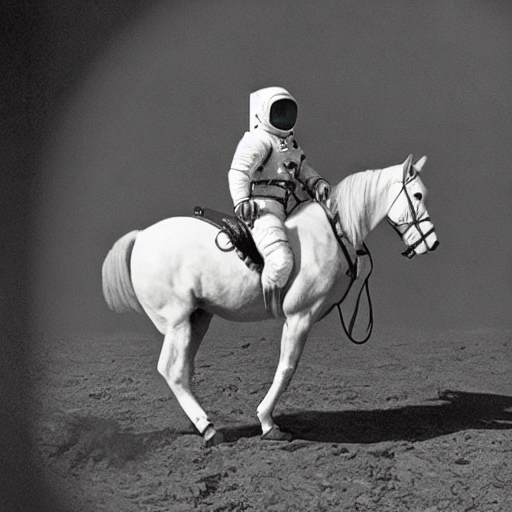

In [ ]:
from diffusers import StableDiffusionPipeline

# set up the pipeline to generate images
pipe = StableDiffusionPipeline.from_pretrained(
    'CompVis/stable-diffusion-v1-4').to('cuda')

prompt = "a photograph of an astronaut riding a horse"
# generate an image for the above prompt
pipe(prompt).images[0]

  0%|          | 0/51 [00:00<?, ?it/s]

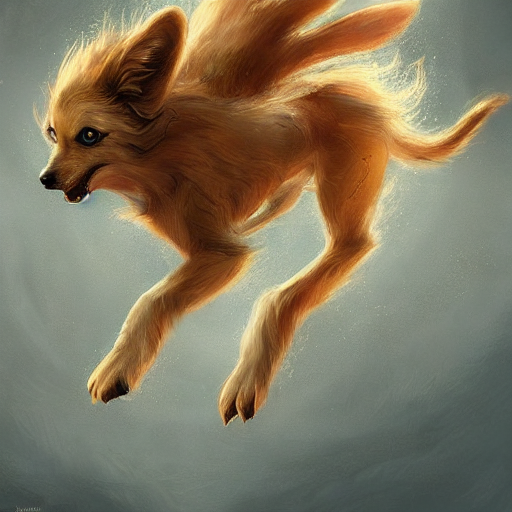

In [ ]:
prompt = "a cute magical flying dog, fantasy art, golden color, high quality, highly detailed, elegant, sharp focus," \
    "concept art, character concepts, digital painting, mystery, adventure"
# generate an image for the above prompt
pipe(prompt).images[0]

The results from text-to-image models can vary based on the text prompt. *Prompt engineering* involves customizing the text prompts to influence the generated images. Examples include specifying different styles of image types lighting, painting styles, focus, etc.

## Appendix <a name='appendix'></a>

**The material in the Appendix is not required for quizzes and assignments.**

###Interpolation Between Prompts

Text-to-image models can also be used to interpolate between different text prompts. This is referred to as *latent space walking* or *latent space exploration* because the model samples points in the latent space and incrementally changes the latent representation to reach from one text prompt to another text prompt.

One application is shown below, where each sampled point is saved as a frame, and a gif animation is created that shows the latent space walking between two prompts.

It is also possible to include multiple different text prompts and explore the latent space between them.

In [ ]:
# Code from: https://github.com/svpino/stable-diffusion/blob/main/stable-diffusion.ipynb

PROMPT1 = "a ford truck"
PROMPT2 = "an electric car"

# number of interpolation steps between the two text prompts
INTERPOLATION_STEPS = 42

# number of frames per second
FRAMES_PER_SECOND = 10

# number of diffusion steps
DIFFUSION_STEPS = 25

# name of the file
ANIMATION_FILENAME = "animation.gif"

SEED = 42

In [ ]:
import tensorflow as tf
from PIL import Image

# random noise patch
noise = tf.random.normal((512 // 8, 512 // 8, 4), seed=SEED)

# encoded vectors for the two text prompts
encoding1 = tf.squeeze(model.encode_text(PROMPT1))
encoding2 = tf.squeeze(model.encode_text(PROMPT2))

# generate the interpolation steps between the two encoded prompts
interpolated_encodings = tf.linspace(encoding1, encoding2, INTERPOLATION_STEPS)

# split the encodings into batches
batch_size = 3
batches = INTERPOLATION_STEPS // batch_size
encodings = tf.split(interpolated_encodings, batches)

animation = []
for batch in range(batches):
    # generate images
    images = model.generate_image(
        encodings[batch],
        batch_size=batch_size,
        num_steps=DIFFUSION_STEPS,
        diffusion_noise=noise,
    )

    # add the images to the animation
    animation.extend(map(lambda image: Image.fromarray(image), images))

def export_as_gif(images, filename, frames_per_second=10):
    """
    Exports the supplied images as a GIF animation.
    """
    images += images[2:-1][::-1]
    images[0].save(filename, save_all=True, append_images=images[1:],
        duration=1000 // frames_per_second, loop=0)

# Export the animation as a GIF and display it on the screen.
export_as_gif(animation, ANIMATION_FILENAME, frames_per_second=FRAMES_PER_SECOND)

25/25 [==============================] - 8s 337ms/step


<img src='https://raw.githubusercontent.com/avakanski/Fall-2022-Python-Programming-for-Data-Science/main/Lectures/Theme%203%20-%20Model%20Engineering%20Pipelines/Lecture%2022%20-%20Diffusion%20Models/images/animation.gif' width=800px/>

<img src="images/animation.gif" width="800">

*Figure: Latent space walking from a Ford truck to an electric car.*

## References <a name='references'></a>

1. High-performance image generation using Stable Diffusion in KerasCV, available at [https://keras.io/guides/keras_cv/generate_images_with_stable_diffusion/](https://keras.io/guides/keras_cv/generate_images_with_stable_diffusion/).
2. Diffusion Models Made Easy, J. Rafid Siddiqui, available at [https://towardsdatascience.com/diffusion-models-made-easy-8414298ce4da](https://towardsdatascience.com/diffusion-models-made-easy-8414298ce4da).
3. How Diffusion Models Work: The Math From Scratch, available at [https://theaisummer.com/diffusion-models/](https://theaisummer.com/diffusion-models/).
4. The Illustrated Stable Diffusion, Jay Alammar, available at [https://jalammar.github.io/illustrated-stable-diffusion/](https://jalammar.github.io/illustrated-stable-diffusion/).
5. What are Stable Diffusion Models and Why are they a Step Forward for Image Generation?, J. Rafid Siddiqui, available at [https://towardsdatascience.com/what-are-stable-diffusion-models-and-why-are-they-a-step-forward-for-image-generation-aa1182801d46](https://towardsdatascience.com/what-are-stable-diffusion-models-and-why-are-they-a-step-forward-for-image-generation-aa1182801d46).
6. Generating Images using Stable Diffusion, available at [https://github.com/svpino/stable-diffusion/blob/main/stable-diffusion.ipynb](https://github.com/svpino/stable-diffusion/blob/main/stable-diffusion.ipynb).

[BACK TO TOP](#top)